In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import seaborn as sns
from scipy.sparse import csc_matrix
import random
random.seed(123)
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed


In [2]:
nested_dict={'B cell': {'Effector B cell': ['CD27+ effector B cell',
   'CD27- effector B cell'],
  'Memory B cell': ['Core memory B cell',
   'Early memory B cell',
   'Type 2 polarized memory B cell',
   'CD95 memory B cell',
   'Activated memory B cell'],
  'Naive B cell': ['Core naive B cell', 'ISG+ naive B cell'],
  'Plasma cell': ['Plasma cell'],
  'Transitional B cell': ['Transitional B cell']},
 'DC': {'ASDC': ['ASDC'],
  'cDC1': ['cDC1'],
  'cDC2': ['CD14+ cDC2', 'HLA-DRhi cDC2', 'ISG+ cDC2'],
  'pDC': ['pDC']},
 'Erythrocyte': {'Erythrocyte': ['Erythrocyte']},
 'ILC': {'ILC': ['ILC']},
 'Monocyte': {'CD14 monocyte': ['Core CD14 monocyte',
   'ISG+ CD14 monocyte',
   'IL1B+ CD14 monocyte'],
  'CD16 monocyte': ['Core CD16 monocyte',
   'ISG+ CD16 monocyte',
   'C1Q+ CD16 monocyte'],
  'Intermediate monocyte': ['Intermediate monocyte']},
 'NK cell': {'CD56bright NK cell': ['CD56bright NK cell'],
  'CD56dim NK cell': ['Adaptive NK cell',
   'GZMK+ CD56dim NK cell',
   'GZMK- CD56dim NK cell',
   'ISG+ CD56dim NK cell'],
  'Proliferating NK cell': ['Proliferating NK cell']},
 'Platelet': {'Platelet': ['Platelet']},
 'Progenitor cell': {'Progenitor cell': ['CMP cell',
   'CLP cell',
   'BaEoMaP cell']},
 'T cell': {'CD8aa': ['CD8aa'],
  'DN T cell': ['DN T cell'],
  'MAIT': ['CD8 MAIT', 'CD4 MAIT', 'ISG+ MAIT'],
  'Memory CD4 T cell': ['CM CD4 T cell',
   'GZMB- CD27+ EM CD4 T cell',
   'GZMB- CD27- EM CD4 T cell',
   'ISG+ memory CD4 T cell',
   'KLRF1- GZMB+ CD27- memory CD4 T cell'],
  'Memory CD8 T cell': ['GZMK+ CD27+ EM CD8 T cell',
   'CM CD8 T cell',
   'KLRF1- GZMB+ CD27- EM CD8 T cell',
   'GZMK- CD27+ EM CD8 T cell',
   'KLRF1+ GZMB+ CD27- EM CD8 T cell',
   'ISG+ memory CD8 T cell'],
  'Naive CD4 T cell': ['Core naive CD4 T cell',
   'SOX4+ naive CD4 T cell',
   'ISG+ naive CD4 T cell'],
  'Naive CD8 T cell': ['Core naive CD8 T cell',
   'SOX4+ naive CD8 T cell',
   'ISG+ naive CD8 T cell'],
  'Proliferating T cell': ['Proliferating T cell'],
  'Treg': ['Naive CD4 Treg',
   'Memory CD4 Treg',
   'KLRB1+ memory CD4 Treg',
   'Memory CD8 Treg',
   'GZMK+ memory CD4 Treg',
   'KLRB1+ memory CD8 Treg'],
  'gdT': ['GZMK+ Vd2 gdT',
   'GZMB+ Vd2 gdT',
   'Naive Vd1 gdT',
   'KLRF1+ effector Vd1 gdT',
   'SOX4+ Vd1 gdT',
   'KLRF1- effector Vd1 gdT']}}

In [3]:
meta_data=pd.read_csv('/home/jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data=meta_data[meta_data['Covid_exlcusion']=='no']
TimePoints=['Flu Year 1 Day 0']
meta_data_subset=meta_data[meta_data['sample.visitName'].isin(TimePoints)]

In [4]:
from tqdm import tqdm
h5_list = []
for i in tqdm(range(len(meta_data_subset["pbmc_sample_id"].tolist()))):
    try:
        result = sc.read_h5ad("/home/jupyter/BRI_Analysis/scRNA/h5_cleaned_by_sample/"+meta_data_subset["pbmc_sample_id"].tolist()[i]+'.h5ad')
        h5_list.append(result)
        print()
    except Exception as e:
        print(f'Error reading {file_name}: {e}')

  1% 1/92 [00:02<04:05,  2.70s/it]

  2% 2/92 [00:04<03:13,  2.15s/it]

  3% 3/92 [00:06<02:54,  1.96s/it]

  4% 4/92 [00:07<02:41,  1.83s/it]

  5% 5/92 [00:10<02:52,  1.99s/it]

  7% 6/92 [00:11<02:40,  1.87s/it]

  8% 7/92 [00:13<02:40,  1.88s/it]

  9% 8/92 [00:15<02:30,  1.79s/it]

 10% 9/92 [00:16<02:22,  1.71s/it]

 11% 10/92 [00:18<02:23,  1.76s/it]

 12% 11/92 [00:20<02:22,  1.76s/it]

 13% 12/92 [00:22<02:17,  1.72s/it]

 14% 13/92 [00:23<02:14,  1.70s/it]

 15% 14/92 [00:25<02:06,  1.63s/it]

 16% 15/92 [00:26<02:10,  1.69s/it]

 17% 16/92 [00:28<02:09,  1.70s/it]

 18% 17/92 [00:30<02:14,  1.79s/it]

 20% 18/92 [00:32<02:13,  1.80s/it]

 21% 19/92 [00:34<02:07,  1.75s/it]

 22% 20/92 [00:35<02:02,  1.70s/it]

 23% 21/92 [00:37<02:00,  1.70s/it]

 24% 22/92 [00:39<02:12,  1.89s/it]

 25% 23/92 [00:42<02:18,  2.01s/it]

 26% 24/92 [00:44<02:18,  2.04s/it]

 27% 25/92 [00:46<02:17,  2.05s/it]

 28% 26/92 [00:48<02:13,  2.02s/it]

 29% 27/92 [00:50<02:13,  2.06s/it]

 30% 28/92 [00:52<02:16,  2.13s/it]

 32% 29/92 [00:54<02:01,  1.93s/it]

 33% 30/92 [00:56<02:01,  1.96s/it]

 34% 31/92 [00:58<01:58,  1.94s/it]

 35% 32/92 [01:00<01:56,  1.95s/it]

 36% 33/92 [01:01<01:50,  1.88s/it]

 37% 34/92 [01:03<01:50,  1.91s/it]

 38% 35/92 [01:06<02:02,  2.15s/it]

 39% 36/92 [01:07<01:47,  1.92s/it]

 40% 37/92 [01:09<01:47,  1.96s/it]

 41% 38/92 [01:11<01:43,  1.91s/it]

 42% 39/92 [01:13<01:39,  1.88s/it]

 43% 40/92 [01:15<01:37,  1.88s/it]

 45% 41/92 [01:17<01:42,  2.01s/it]

 46% 42/92 [01:18<01:26,  1.73s/it]

 47% 43/92 [01:21<01:33,  1.92s/it]

 48% 44/92 [01:22<01:25,  1.78s/it]

 49% 45/92 [01:24<01:24,  1.81s/it]

 50% 46/92 [01:25<01:19,  1.73s/it]

 51% 47/92 [01:27<01:21,  1.82s/it]

 52% 48/92 [01:30<01:25,  1.94s/it]

 53% 49/92 [01:31<01:19,  1.85s/it]

 54% 50/92 [01:33<01:21,  1.93s/it]

 55% 51/92 [01:35<01:18,  1.92s/it]

 57% 52/92 [01:38<01:21,  2.03s/it]

 58% 53/92 [01:40<01:20,  2.07s/it]

 59% 54/92 [01:41<01:14,  1.95s/it]

 60% 55/92 [01:44<01:17,  2.10s/it]

 61% 56/92 [01:46<01:18,  2.18s/it]

 62% 57/92 [01:49<01:20,  2.31s/it]

 63% 58/92 [01:51<01:14,  2.20s/it]

 64% 59/92 [01:52<01:07,  2.03s/it]

 65% 60/92 [01:54<00:59,  1.86s/it]

 66% 61/92 [01:55<00:52,  1.70s/it]

 67% 62/92 [01:57<00:54,  1.82s/it]

 68% 63/92 [01:59<00:51,  1.77s/it]

 70% 64/92 [02:01<00:52,  1.86s/it]

 71% 65/92 [02:03<00:48,  1.80s/it]

 72% 66/92 [02:04<00:46,  1.78s/it]

 73% 67/92 [02:06<00:44,  1.77s/it]

 74% 68/92 [02:08<00:42,  1.77s/it]

 75% 69/92 [02:10<00:43,  1.87s/it]

 76% 70/92 [02:12<00:42,  1.93s/it]

 77% 71/92 [02:14<00:37,  1.79s/it]

 78% 72/92 [02:15<00:33,  1.69s/it]

 79% 73/92 [02:17<00:32,  1.74s/it]

 80% 74/92 [02:19<00:31,  1.73s/it]

 82% 75/92 [02:20<00:27,  1.63s/it]

 83% 76/92 [02:22<00:25,  1.60s/it]

 84% 77/92 [02:23<00:23,  1.59s/it]

 85% 78/92 [02:25<00:23,  1.68s/it]

 86% 79/92 [02:27<00:23,  1.79s/it]

 87% 80/92 [02:29<00:23,  1.92s/it]

 88% 81/92 [02:31<00:21,  1.95s/it]

 89% 82/92 [02:34<00:20,  2.03s/it]

 90% 83/92 [02:35<00:17,  1.99s/it]

 91% 84/92 [02:37<00:15,  1.91s/it]

 92% 85/92 [02:39<00:13,  1.90s/it]

 93% 86/92 [02:41<00:11,  1.86s/it]

 95% 87/92 [02:43<00:09,  1.83s/it]

 96% 88/92 [02:44<00:07,  1.79s/it]

 97% 89/92 [02:45<00:04,  1.52s/it]

 98% 90/92 [02:47<00:03,  1.60s/it]

 99% 91/92 [02:49<00:01,  1.71s/it]

100% 92/92 [02:51<00:00,  1.86s/it]

In [5]:
%%time
combined= anndata.concat(h5_list)
combined.obs.index=combined.obs['barcodes']

CPU times: user 8.02 s, sys: 7.78 s, total: 15.8 s
Wall time: 15.9 s


In [6]:
combined

AnnData object with n_obs × n_vars = 1542995 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'

In [7]:
Immune_Type=pd.read_csv('SLP_Immunotype_Assignments.csv')

In [8]:
Immune_Type.columns=['ImmuneType','subject.subjectGuid']

In [9]:
obs_meta=combined.obs.merge(Immune_Type, how='left',on='subject.subjectGuid')

In [10]:
np.unique(obs_meta['barcodes']==combined.obs['barcodes'].tolist())

array([ True])

In [11]:
combined.obs['ImmuneType']=obs_meta['ImmuneType'].tolist()

In [12]:
[item for sublist in nested_dict['Monocyte'].values() for item in sublist]

['Core CD14 monocyte',
 'ISG+ CD14 monocyte',
 'IL1B+ CD14 monocyte',
 'Core CD16 monocyte',
 'ISG+ CD16 monocyte',
 'C1Q+ CD16 monocyte',
 'Intermediate monocyte']

In [13]:
selected_celltype=[item for sublist in nested_dict['DC'].values() for item in sublist]+[item for sublist in nested_dict['Monocyte'].values() for item in sublist]

In [14]:
combined_MonoDC=combined[combined.obs['AIFI_L3'].isin (selected_celltype)]


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [15]:
sc.pp.normalize_total(combined_MonoDC, target_sum=1e4)
sc.pp.log1p(combined_MonoDC)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
combined_MonoDC.obs['ImmuneType']= [str(x) for x in combined_MonoDC.obs['ImmuneType']]

In [17]:
import matplotlib.backends.backend_pdf

ASDC


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235:

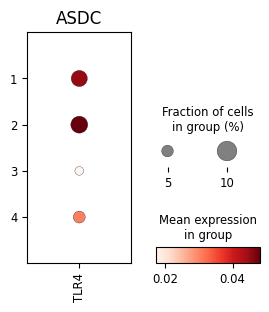

cDC1


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

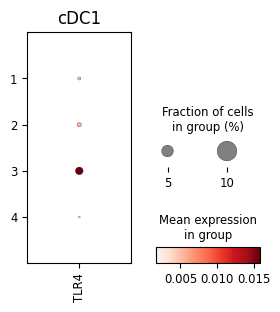

CD14+ cDC2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

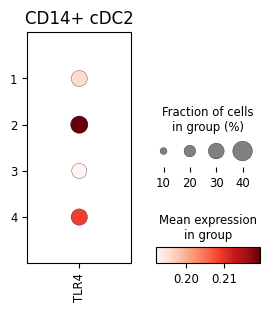

HLA-DRhi cDC2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

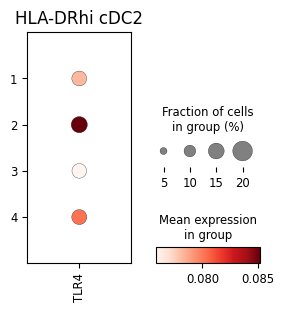

ISG+ cDC2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

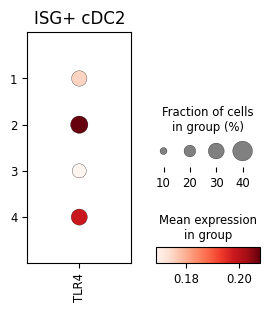

pDC


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

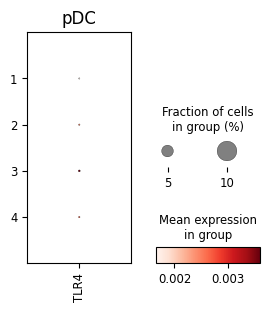

Core CD14 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

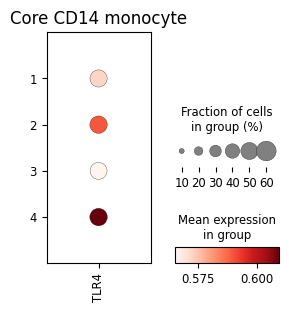

ISG+ CD14 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

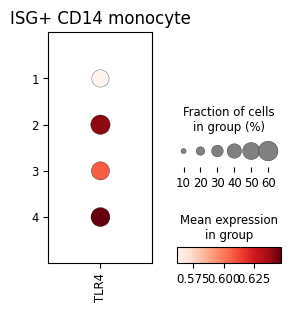

IL1B+ CD14 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

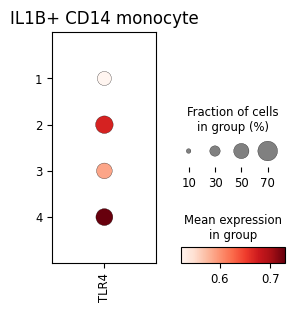

Core CD16 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

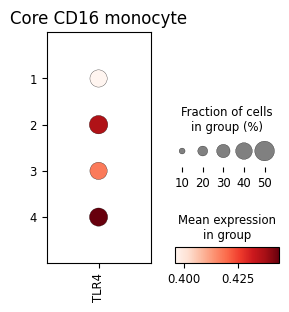

ISG+ CD16 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

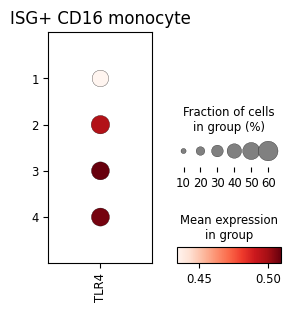

C1Q+ CD16 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

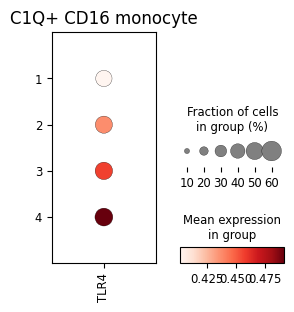

Intermediate monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

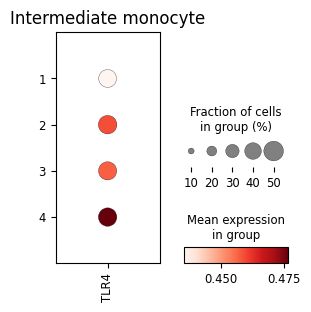

In [18]:
for i in selected_celltype:
    print(i)
    combined_MonoDC_sub=combined_MonoDC[combined_MonoDC.obs['AIFI_L3']==i]
    sc.pl.dotplot(combined_MonoDC_sub, ['TLR4'], 'ImmuneType', use_raw=False, title=i,
                  dendrogram=False,figsize=(3,3))

In [19]:
import matplotlib.pyplot as plt

In [20]:
pdf = matplotlib.backends.backend_pdf.PdfPages("output_plots.pdf")

# Loop through the selected cell types
for i in selected_celltype:
    print(i)
    combined_MonoDC_sub = combined_MonoDC[combined_MonoDC.obs['AIFI_L3'] == i]
    
    # Generate the plot and get the dictionary of axes
    axes_dict = sc.pl.dotplot(combined_MonoDC_sub, ['TLR4'], 'ImmuneType', use_raw=False, title=i,
                              dendrogram=False, figsize=(3, 3), show=False)  # Increased figsize for clarity
    
    # Retrieve and adjust the current figure
    fig = plt.gcf()
    fig.set_size_inches(3, 3)  # Optionally set a new size
    plt.tight_layout()  # Adjust layout to make sure all elements fit within the figure area
    
    # Save the figure to the PDF, ensuring all content is included
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory

# Close the PDF file after saving all plots
pdf.close()


ASDC


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

cDC1


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235:

CD14+ cDC2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

HLA-DRhi cDC2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

ISG+ cDC2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

pDC


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

Core CD14 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

ISG+ CD14 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

IL1B+ CD14 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

Core CD16 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

ISG+ CD16 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

C1Q+ CD16 monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235:

Intermediate monocyte


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/op

In [25]:
def grouped_obs_mean(adata_filt, group_key, layer=None, gene_symbols=None):  #  calculates the mean expression of genes across different groups 
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata_filt.var[idx]
    else:
        new_idx = adata_filt.var_names
    grouped = adata_filt.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata_filt.shape[1], len(grouped)), dtype=np.float64),
        columns=[':'.join(i) for i in list(grouped.groups.keys()) ],
        index=adata_filt.var_names
    )
    for group, idx in grouped.indices.items():
        X = getX(adata_filt[idx])
        out[':'.join(group)] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [52]:
mean_df=grouped_obs_mean(combined_MonoDC,['pbmc_sample_id','AIFI_L3','ImmuneType']).loc['TLR4',]

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [53]:
mean_df=pd.DataFrame(mean_df)

In [54]:
mean_df['Samples']=mean_df.index 

In [55]:
mean_df[['pbmc_sample_id', 'AIFI_L3', 'ImmuneType']] = mean_df['Samples'].str.split(':', expand=True)

In [56]:
mean_df = pd.merge(mean_df, meta_data, on='pbmc_sample_id', how='left')

In [72]:
mean_df.to_csv("mean_df.csv")